# BERT Model: `bert-base-cased`

## Kiến trúc
BERT (Bidirectional Encoder Representations from Transformers) là mô hình học sâu dựa trên kiến trúc Transformer được phát triển bởi Google (2018). Khác với các mô hình trước đó, BERT sử dụng tính năng biểu diễn hai chiều (bidirectional) - có thể học được bối cảnh từ cả hai hướng của văn bản.

### Đặc điểm kiến trúc của `bert-base-cased`:
- **12 lớp Encoder Transformer**
- **12 attention heads** trong mỗi lớp self-attention
- **Chiều ẩn: 768** (hidden dimensions)
- **Quá trình pre-training** trên bộ dữ liệu lớn gồm:
    - BooksCorpus (800M từ)
    - Wikipedia tiếng Anh (2,500M từ)

### Phương pháp huấn luyện
1. **Masked Language Modeling (MLM)**: Che ngẫu nhiên 15% các token và dự đoán chúng
2. **Next Sentence Prediction (NSP)**: Dự đoán xem câu B có thực sự là câu tiếp theo của câu A không

## Điểm đặc biệt của `bert-base-cased`
- **Phân biệt chữ hoa/thường** (case-sensitive): Điều này đặc biệt quan trọng cho các tác vụ NER nơi viết hoa có thể là dấu hiệu của một thực thể
- **WordPiece tokenization**: Phân tách từ thành các subwords, giúp xử lý từ hiếm hoặc từ chưa gặp
- **Mã hóa vị trí**: Sử dụng positional encoding để duy trì thông tin về vị trí của từng token

## Tổng số tham số
- **110 triệu** tham số có thể huấn luyện
- Kích thước nhỏ hơn so với phiên bản `bert-large` (340 triệu tham số)

## Ưu điểm
1. **Hiệu suất cao**: Đạt kết quả tốt trên nhiều tác vụ NLP
2. **Biểu diễn ngữ cảnh phong phú**: Nắm bắt được ngữ cảnh hai chiều
3. **Linh hoạt**: Có thể fine-tune cho nhiều tác vụ downstream khác nhau
4. **Phân biệt chữ hoa/thường**: Quan trọng với tác vụ nhận dạng thực thể (NER)
5. **Cân bằng tốt giữa hiệu suất và tài nguyên**: Nhẹ hơn phiên bản large nhưng vẫn đủ mạnh cho nhiều ứng dụng

## So sánh với các phiên bản BERT khác

| Model | Layers | Hidden Size | Heads | Parameters | Case Sensitive |
|-------|--------|-------------|-------|------------|---------------|
| bert-base-uncased | 12 | 768 | 12 | 110M | Không |
| **bert-base-cased** | **12** | **768** | **12** | **110M** | **Có** |
| bert-large-cased | 24 | 1024 | 16 | 340M | Có |

In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
namanj27_ner_dataset_path = kagglehub.dataset_download('namanj27/ner-dataset')
tcc3281_lstm_pytorch_default_3_path = kagglehub.model_download('tcc3281/lstm/PyTorch/default/3')

print('Data source import complete.')


Data source import complete.


In [2]:
import sys
sys.path.append(tcc3281_lstm_pytorch_default_3_path)
from transformers import AutoTokenizer, AutoModelForMaskedLM
import pandas as pd
import torch
from main import*
from tqdm.notebook import tqdm  # Use tqdm.notebook for Jupyter compatibility
# Import thư viện cần thiết
from transformers import AutoModelForTokenClassification, get_linear_schedule_with_warmup
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torch
from tqdm.notebook import tqdm
import torch
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# 1. Data Processing

### Quy trình xử lý data
```mermaid
graph TD
    A[Start] --> B[Step 1: Load Data]
    B --> C[Step 2]
    C --> C1[ Create Tags Dictionary]
    C --> D[Process Sentence, POS, Tag]
    C --> E[Step 3]
    
subgraph Z[Tokenize]
    E1 --> F[Tokenize Sentence]
    F --> G[Create Labels, Retrieve word_ids]
    G --> I[Iterate]
    I --> J[If work_idx is None => -100]
    I --> K[If Current word_id != Previous => New Tags]
    I --> L[Else => -100]
    L --> M[Convert ID to Token]
    K --> M
    J --> M
    M --> R[Return encodeing, label, token]
end
    E --> Z
    D --> Z
    E --> N[Create id2label and label2id]
    C1 --> N
    N --> O[End]
    C1 -->O
    R --> O
```
## Giải thích về BERT Tokenization

Trong **BERT**, token là các đơn vị nhỏ nhất mà mô hình xử lý. Chúng không phải lúc nào cũng là từ đầy đủ, mà thường là các **subword** (một phần của từ) hoặc các ký hiệu đặc biệt. BERT sử dụng thuật toán **WordPiece** để chia văn bản thành các token.

**Ví dụ:** "playing" → [play, ##ing]

**Lợi ích của tokenization:**
- **Từ điển giới hạn** - Quản lý hiệu quả kích thước từ điển
- **Xử lý từ hiếm** - Phân tách từ hiếm thành các phần quen thuộc hơn
- **Hiệu quả** về mặt tính toán và biểu diễn

### Các thành phần chính:

- **Token:**
    - Subword (phần của từ)
    - Từ đầy đủ
    - Token đặc biệt: `[CLS]`, `[SEP]`, `[PAD]`, `[UNK]`

- **Input IDs:**
    - Mỗi token được ánh xạ thành một số nguyên (ID) dựa trên từ điển
    - Mô hình BERT chỉ hiểu các số này, không hiểu chuỗi văn bản trực tiếp
    - **Ví dụ:** "I love NLP" → ["I", "love", "NL", "##P"] → [1045, 2293, 18355, 1035]

- **Word IDs:**
    - Danh sách ánh xạ các token về vị trí từ gốc trong câu
    - Giúp xác định token nào thuộc từ nào trước khi bị chia nhỏ

- **Attention Mask:**
    - Danh sách các số 0 và 1
    - Cho biết token nào thực sự quan trọng (1) và token nào là đệm (0)
    - Giúp BERT tập trung vào các token có ý nghĩa   

### Các token đặc biệt trong BERT:

| Token | Ý nghĩa | Cách sử dụng |
|-------|---------|--------------|
| [CLS] | Classification | Đầu mỗi chuỗi, dùng cho phân loại |
| [SEP] | Separator | Ngăn cách giữa các chuỗi văn bản |
| [PAD] | Padding | Đệm để các chuỗi cùng độ dài |
| [UNK] | Unknown | Đại diện cho từ không có trong từ điển |
| [MASK] | Masking | Che từ để mô hình dự đoán trong MLM |

## Preprocessing

In [3]:
path=f'{namanj27_ner_dataset_path}/ner_datasetreference.csv'

In [4]:
df = pd.read_csv(path, encoding='latin1')
df.head(10)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O
5,NaN,through,IN,O
6,NaN,London,NNP,B-geo
7,NaN,to,TO,O
8,NaN,protest,VB,O
9,NaN,the,DT,O


In [5]:
df.shape

(1048575, 4)

In [6]:
tags_dic = {}
for i, tag in enumerate(df['Tag'].unique()):
    tags_dic[tag] = i
tags_dic

{'O': 0,
 'B-geo': 1,
 'B-gpe': 2,
 'B-per': 3,
 'I-geo': 4,
 'B-org': 5,
 'I-org': 6,
 'B-tim': 7,
 'B-art': 8,
 'I-art': 9,
 'I-per': 10,
 'I-gpe': 11,
 'I-tim': 12,
 'B-nat': 13,
 'B-eve': 14,
 'I-eve': 15,
 'I-nat': 16}

In [7]:
# check number of unique tags
df['Sentence #'].unique()

array(['Sentence: 1', nan, 'Sentence: 2', ..., 'Sentence: 47957',
       'Sentence: 47958', 'Sentence: 47959'], dtype=object)

In [8]:
data=pd.DataFrame(columns=['Sentence','POS','Tag'])

In [9]:
sen=[]
pos=[]
tag=[]
# Add tqdm to show progress over DataFrame rows
for _, row in tqdm(df.iterrows(), total=len(df), desc="Processing sentences"):
    # check if the sentence is NaN
    if not pd.isna(row['Sentence #']):
        # Don't add empty sentence at the beginning
        if sen:
            # add the sen, pos, and tag to the dataframe
            data.loc[len(data)] = {
                'Sentence': sen.copy(),
                'POS': pos.copy(),
                'Tag': tag.copy()
            }
            sen.clear()
            pos.clear()
            tag.clear()
    sen.append(row['Word'])
    pos.append(row['POS'])
    tag.append(row['Tag'])

# Add the last sentence that won't be caught by the loop
if sen:
    data.loc[len(data)] = {
        'Sentence': sen.copy(),
        'POS': pos.copy(),
        'Tag': tag.copy()
    }

Processing sentences:   0%|          | 0/1048575 [00:00<?, ?it/s]

In [10]:
data.head(10)

,Sentence,POS,Tag
0,"[Thousands, of, demonstrators, have, marched, ...","[NNS, IN, NNS, VBP, VBN, IN, NNP, TO, VB, DT, ...","[O, O, O, O, O, O, B-geo, O, O, O, O, O, B-geo..."
1,"[Families, of, soldiers, killed, in, the, conf...","[NNS, IN, NNS, VBN, IN, DT, NN, VBD, DT, NNS, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
2,"[They, marched, from, the, Houses, of, Parliam...","[PRP, VBD, IN, DT, NNS, IN, NN, TO, DT, NN, IN...","[O, O, O, O, O, O, O, O, O, O, O, B-geo, I-geo..."
3,"[Police, put, the, number, of, marchers, at, 1...","[NNS, VBD, DT, NN, IN, NNS, IN, CD, IN, NNS, V...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]"
4,"[The, protest, comes, on, the, eve, of, the, a...","[DT, NN, VBZ, IN, DT, NN, IN, DT, JJ, NN, IN, ...","[O, O, O, O, O, O, O, O, O, O, O, B-geo, O, O,..."
5,"[The, party, is, divided, over, Britain, 's, p...","[DT, NN, VBZ, VBN, IN, NNP, POS, NN, IN, DT, N...","[O, O, O, O, O, B-gpe, O, O, O, O, B-geo, O, O..."
6,"[The, London, march, came, ahead, of, anti-war...","[DT, NNP, NN, VBD, RB, IN, JJ, NNS, NN, IN, JJ...","[O, B-geo, O, O, O, O, O, O, O, O, O, O, O, O,..."
7,"[The, International, Atomic, Energy, Agency, i...","[DT, NNP, NNP, NNP, NNP, VBZ, TO, VB, JJ, NN, ...","[O, B-org, I-org, I-org, I-org, O, O, O, O, O,..."
8,"[Iran, this, week, restarted, parts, of, the, ...","[NNP, DT, NN, VBD, NNS, IN, DT, NN, NN, IN, PR...","[B-gpe, O, O, O, O, O, O, O, O, O, O, B-geo, O..."
9,"[Iranian, officials, say, they, expect, to, ge...","[JJ, NNS, VBP, PRP, VBP, TO, VB, NN, TO, JJ, J...","[B-gpe, O, O, O, O, O, O, O, O, O, O, O, O, O,..."


In [11]:
data.shape

(47959, 3)

## Tokenizing

In [12]:
model_name = 'bert-base-cased'
tokenizer = AutoTokenizer.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

In [13]:
import numpy as np
import pandas as pd

def tokenize(row):
    # 1) Lấy về mảng các từ
    words = row['Sentence']
    # 2) Ép về list thuần Python
    if isinstance(words, (pd.Series, np.ndarray)):
        words = words.tolist()
    elif not isinstance(words, list):
        words = list(words)
    # 3) Đảm bảo mỗi phần tử là str
    words = [str(w) for w in words]

    # 4) Tokenize
    encoding = tokenizer(
        words,
        is_split_into_words=True,
        return_tensors="pt",
        return_offsets_mapping=True,
        padding="max_length",
        truncation=True,
        max_length=512,
    )

    # 5) Lấy labels tương ứng
    labels = []
    word_ids = encoding.word_ids()
    previous_word_idx = None
    for word_idx in word_ids:
        if word_idx is None:
            labels.append(-100)
        elif word_idx != previous_word_idx:
            labels.append(tags_dic[row['Tag'][word_idx]])
        else:
            labels.append(-100)
        previous_word_idx = word_idx

    # 6) Lấy danh sách token (tuỳ bạn dùng hay không)
    tokens = tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

    return encoding, labels, tokens

In [14]:
# Register tqdm with pandas
tqdm.pandas(desc="Tokenizing")

# Apply tokenize to each row and store the full tuple result with progress tracking
data['tokenized_data'] = data.progress_apply(tokenize, axis=1)

Tokenizing:   0%|          | 0/47959 [00:00<?, ?it/s]

In [15]:
data.head(5)

,Sentence,POS,Tag,tokenized_data
0,"[Thousands, of, demonstrators, have, marched, ...","[NNS, IN, NNS, VBP, VBN, IN, NNP, TO, VB, DT, ...","[O, O, O, O, O, O, B-geo, O, O, O, O, O, B-geo...","([input_ids, token_type_ids, attention_mask, o..."
1,"[Families, of, soldiers, killed, in, the, conf...","[NNS, IN, NNS, VBN, IN, DT, NN, VBD, DT, NNS, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","([input_ids, token_type_ids, attention_mask, o..."
2,"[They, marched, from, the, Houses, of, Parliam...","[PRP, VBD, IN, DT, NNS, IN, NN, TO, DT, NN, IN...","[O, O, O, O, O, O, O, O, O, O, O, B-geo, I-geo...","([input_ids, token_type_ids, attention_mask, o..."
3,"[Police, put, the, number, of, marchers, at, 1...","[NNS, VBD, DT, NN, IN, NNS, IN, CD, IN, NNS, V...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]","([input_ids, token_type_ids, attention_mask, o..."
4,"[The, protest, comes, on, the, eve, of, the, a...","[DT, NN, VBZ, IN, DT, NN, IN, DT, JJ, NN, IN, ...","[O, O, O, O, O, O, O, O, O, O, O, B-geo, O, O,...","([input_ids, token_type_ids, attention_mask, o..."


In [16]:
id2label={v: k for k,v in tags_dic.items()}
label2id=tags_dic
id2label, label2id


({0: 'O',
  1: 'B-geo',
  2: 'B-gpe',
  3: 'B-per',
  4: 'I-geo',
  5: 'B-org',
  6: 'I-org',
  7: 'B-tim',
  8: 'B-art',
  9: 'I-art',
  10: 'I-per',
  11: 'I-gpe',
  12: 'I-tim',
  13: 'B-nat',
  14: 'B-eve',
  15: 'I-eve',
  16: 'I-nat'},
 {'O': 0,
  'B-geo': 1,
  'B-gpe': 2,
  'B-per': 3,
  'I-geo': 4,
  'B-org': 5,
  'I-org': 6,
  'B-tim': 7,
  'B-art': 8,
  'I-art': 9,
  'I-per': 10,
  'I-gpe': 11,
  'I-tim': 12,
  'B-nat': 13,
  'B-eve': 14,
  'I-eve': 15,
  'I-nat': 16})

# 2. Build and Train Model

## Build Model

In [17]:
model = AutoModelForTokenClassification.from_pretrained(
    model_name,
    num_labels=len(tags_dic),
    id2label=id2label,
    label2id=label2id)

2025-05-09 17:46:56.984192: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746812817.175003      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746812817.229021      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
dataset = NERDataset(data)

In [19]:
from collections import Counter

train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
# Use a fixed seed for reproducibility to ensure consistent tag distribution
generator = torch.Generator().manual_seed(42)
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    dataset, [train_size, val_size, test_size], generator=generator)

# Optional: Add this code to verify tag distribution if needed
def check_tag_distribution(split_dataset, name):
    tag_counts = Counter()
    for i in range(len(split_dataset)):
        labels = split_dataset[i]['labels']
        valid_labels = [l for l in labels if l != -100]
        tag_counts.update(valid_labels)

    print(f"\nTag distribution in {name} set:")
    for tag_id, count in sorted(tag_counts.items()):
        if tag_id in id2label:
            print(f"{id2label[tag_id]}: {count}")
train_size, val_size, test_size, len(dataset)

(38367, 4795, 4797, 47959)

In [20]:
batch_size = 16
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [21]:
#prin shape of dataloader
print(f"Train DataLoader: {len(train_dataloader)} batches")
print(f"Validation DataLoader: {len(val_dataloader)} batches")
print(f"Test DataLoader: {len(test_dataloader)} batches")

Train DataLoader: 2398 batches
Validation DataLoader: 300 batches
Test DataLoader: 300 batches


In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

In [23]:
# optimizer and scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-5)
epochs = 5

In [24]:
total_steps = len(train_dataloader) * epochs

In [25]:
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

In [26]:
# Hàm tính độ chính xác
# Hàm tính precision, recall, và F1 score
def compute_metrics(preds, labels):
    # Chỉ tính cho các token không phải -100
    valid_indices = labels != -100
    valid_preds = preds[valid_indices]
    valid_labels = labels[valid_indices]

    # Nếu không có nhãn hợp lệ
    if valid_labels.size(0) == 0:
        return {"precision": 0.0, "recall": 0.0, "f1": 0.0}

    # Tính số lượng true positive, false positive và false negative cho tất cả các lớp
    tp = 0
    fp = 0
    fn = 0

    # Xử lý cho từng lớp
    unique_labels = torch.unique(torch.cat([valid_labels, valid_preds]))
    for label in unique_labels:
        if label == 0:  # Bỏ qua nhãn O (outside any entity)
            continue

        true_positives = ((valid_preds == label) & (valid_labels == label)).sum().item()
        false_positives = ((valid_preds == label) & (valid_labels != label)).sum().item()
        false_negatives = ((valid_preds != label) & (valid_labels == label)).sum().item()

        tp += true_positives
        fp += false_positives
        fn += false_negatives

    # Tính precision, recall và F1
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0

    return precision,  recall, f1


## Train Model

In [27]:
# Vòng lặp huấn luyện
best_val_loss = float('inf')
training_stats = []

for epoch in range(epochs):
    print(f"\n======== Epoch {epoch+1} / {epochs} ========")

    # Training
    model.train()
    total_train_loss = 0
    total_train_precision = 0
    total_train_recall = 0
    total_train_f1 = 0

    progress_bar = tqdm(train_dataloader, desc="Training")

    for batch in progress_bar:
        # Di chuyển batch đến device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Reset gradients
        model.zero_grad()

        # Forward pass
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        loss = outputs.loss
        logits = outputs.logits

        # Backward pass
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Cập nhật tham số
        optimizer.step()
        scheduler.step()

        # Tính độ chính xác
        preds = torch.argmax(logits, dim=2)
        pre,rec,f1 = compute_metrics(preds.cpu(), labels.cpu())

        # Cập nhật loss và accuracy
        total_train_loss += loss.item()
        total_train_precision += pre
        total_train_recall += rec
        total_train_f1 += f1

        # Cập nhật progress bar
        progress_bar.set_postfix({
            'loss': loss.item(),
            'precision': pre,
            'recall': rec,
            'f1': f1
        })

    # Tính trung bình loss và accuracy cho epoch
    avg_train_loss = total_train_loss / len(train_dataloader)
    avg_train_precision = total_train_precision / len(train_dataloader)
    avg_train_recall = total_train_recall / len(train_dataloader)
    avg_train_f1 = total_train_f1 / len(train_dataloader)

    print(f"  Average training loss: {avg_train_loss:.4f}")
    print(f"  Average training precision: {avg_train_precision:.4f}")
    print(f"  Average training recall: {avg_train_recall:.4f}")
    print(f"  Average training F1: {avg_train_f1:.4f}")

    # Validation
    model.eval()
    total_val_loss = 0
    total_val_precision = 0
    total_val_recall = 0
    total_val_f1 = 0

    with torch.no_grad():
        for batch in tqdm(val_dataloader, desc="Validation"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            loss = outputs.loss
            logits = outputs.logits

            preds = torch.argmax(logits, dim=2)
            pre,rec,f1 = compute_metrics(preds.cpu(), labels.cpu())

            total_val_loss += loss.item()
            total_val_precision += pre
            total_val_recall += rec
            total_val_f1 += f1

    avg_val_loss = total_val_loss / len(val_dataloader)
    avg_val_precision = total_val_precision / len(val_dataloader)
    avg_val_recall = total_val_recall / len(val_dataloader)
    avg_val_f1 = total_val_f1 / len(val_dataloader)

    print(f"  Average validation loss: {avg_val_loss:.4f}")
    print(f"  Average validation precision: {avg_val_precision:.4f}")
    print(f"  Average validation recall: {avg_val_recall:.4f}")
    print(f"  Average validation F1: {avg_val_f1:.4f}")

    # Lưu mô hình tốt nhất
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        # Lưu mô hình
        print("Lưu mô hình tốt nhất...")
        model_path = "ner_best_model"
        model.save_pretrained(model_path)
        tokenizer.save_pretrained(model_path)

    # Lưu thống kê huấn luyện
    training_stats.append({
        'epoch': epoch + 1,
        'train_loss': avg_train_loss,
        'train_precision': avg_train_precision,
        'train_recall': avg_train_recall,
        'train_f1': avg_train_f1,
        'val_loss': avg_val_loss,
        'val_precision': avg_val_precision,
        'val_recall': avg_val_recall,
        'val_f1': avg_val_f1
    })


======== Epoch 1 / 5 ========


Training:   0%|          | 0/2398 [00:00<?, ?it/s]

  Average training loss: 0.1224
  Average training precision: 0.8281
  Average training recall: 0.8097
  Average training F1: 0.8179


Validation:   0%|          | 0/300 [00:00<?, ?it/s]

  Average validation loss: 0.0860
  Average validation precision: 0.8613
  Average validation recall: 0.8575
  Average validation F1: 0.8589
Lưu mô hình tốt nhất...

======== Epoch 2 / 5 ========


Training:   0%|          | 0/2398 [00:00<?, ?it/s]

  Average training loss: 0.0737
  Average training precision: 0.8824
  Average training recall: 0.8689
  Average training F1: 0.8752


Validation:   0%|          | 0/300 [00:00<?, ?it/s]

  Average validation loss: 0.0808
  Average validation precision: 0.8715
  Average validation recall: 0.8652
  Average validation F1: 0.8679
Lưu mô hình tốt nhất...

======== Epoch 3 / 5 ========


Training:   0%|          | 0/2398 [00:00<?, ?it/s]

  Average training loss: 0.0527
  Average training precision: 0.9114
  Average training recall: 0.9040
  Average training F1: 0.9074


Validation:   0%|          | 0/300 [00:00<?, ?it/s]

  Average validation loss: 0.0875
  Average validation precision: 0.8754
  Average validation recall: 0.8604
  Average validation F1: 0.8674

======== Epoch 4 / 5 ========


Training:   0%|          | 0/2398 [00:00<?, ?it/s]

  Average training loss: 0.0369
  Average training precision: 0.9364
  Average training recall: 0.9325
  Average training F1: 0.9343


Validation:   0%|          | 0/300 [00:00<?, ?it/s]

  Average validation loss: 0.0960
  Average validation precision: 0.8683
  Average validation recall: 0.8698
  Average validation F1: 0.8686

======== Epoch 5 / 5 ========


Training:   0%|          | 0/2398 [00:00<?, ?it/s]

  Average training loss: 0.0266
  Average training precision: 0.9532
  Average training recall: 0.9508
  Average training F1: 0.9519


Validation:   0%|          | 0/300 [00:00<?, ?it/s]

  Average validation loss: 0.1051
  Average validation precision: 0.8685
  Average validation recall: 0.8694
  Average validation F1: 0.8685


# 3. Evaluate

In [28]:
def predict_entities(text, model, tokenizer):
    # Chuyển text thành danh sách các từ
    words = text.split()

    # Tokenize
    inputs = tokenizer(
        words,
        is_split_into_words=True,
        return_tensors="pt",
        padding=True,
        truncation=True,
        return_offsets_mapping=True
    )

    # Di chuyển đến device
    input_ids = inputs["input_ids"].to(device)
    attention_mask = inputs["attention_mask"].to(device)

    # Dự đoán
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        predictions = torch.argmax(outputs.logits, dim=2)

    # Chuyển đổi predictions thành nhãn
    predicted_labels = []
    word_ids = inputs.word_ids()

    for idx, pred in enumerate(predictions[0].cpu().numpy()):
        word_idx = word_ids[idx]
        if word_idx is not None:  # Bỏ qua special tokens
            if idx == 0 or word_ids[idx-1] != word_idx:  # Chỉ lấy nhãn đầu tiên của mỗi từ
                # Add safety check for id2label
                if pred in id2label:
                    predicted_labels.append(id2label[pred])
                else:
                    # Default to 'O' (Outside any entity) or you could log this
                    predicted_labels.append('O')

    # Tạo kết quả
    results = []
    for word, label in zip(words, predicted_labels):
        results.append((word, label))

    return results

In [29]:
# Kiểm tra mô hình với một câu mẫu
sample_text = "Ho Chi Minh was born in Vietnam and he is a great man."
entities = predict_entities(sample_text, model, tokenizer)

print("Kết quả nhận dạng thực thể:")
for word, tag in entities:
    print(f"{word}: {tag}")

Kết quả nhận dạng thực thể:
Ho: B-per
Chi: I-per
Minh: I-per
was: O
born: O
in: O
Vietnam: B-geo
and: O
he: O
is: O
a: O
great: O
man.: O


## Metrics

In [30]:
# Đánh giá trên tập test
model.eval()

total_test_loss = 0.0
total_test_precision = 0.0
total_test_recall = 0.0
total_test_f1 = 0.0

with torch.no_grad():
    for batch in tqdm(test_dataloader, desc="Testing"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids,
                        attention_mask=attention_mask,
                        labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        preds = torch.argmax(logits, dim=2)
        pre, rec, f1 = compute_metrics(preds.cpu(), labels.cpu())

        total_test_loss += loss.item()
        total_test_precision += pre
        total_test_recall += rec
        total_test_f1 += f1

# Trung bình trên số batch
n_batches = len(test_dataloader)
avg_test_loss = total_test_loss / n_batches
avg_test_precision = total_test_precision / n_batches
avg_test_recall = total_test_recall / n_batches
avg_test_f1 = total_test_f1 / n_batches

print(f"Average test loss: {avg_test_loss:.4f}")
print(f"Average test precision: {avg_test_precision:.4f}")
print(f"Average test recall: {avg_test_recall:.4f}")
print(f"Average test F1: {avg_test_f1:.4f}")

Testing:   0%|          | 0/300 [00:00<?, ?it/s]

Average test loss: 0.1133
Average test precision: 0.8614
Average test recall: 0.8624
Average test F1: 0.8613


## Confusion Matrix

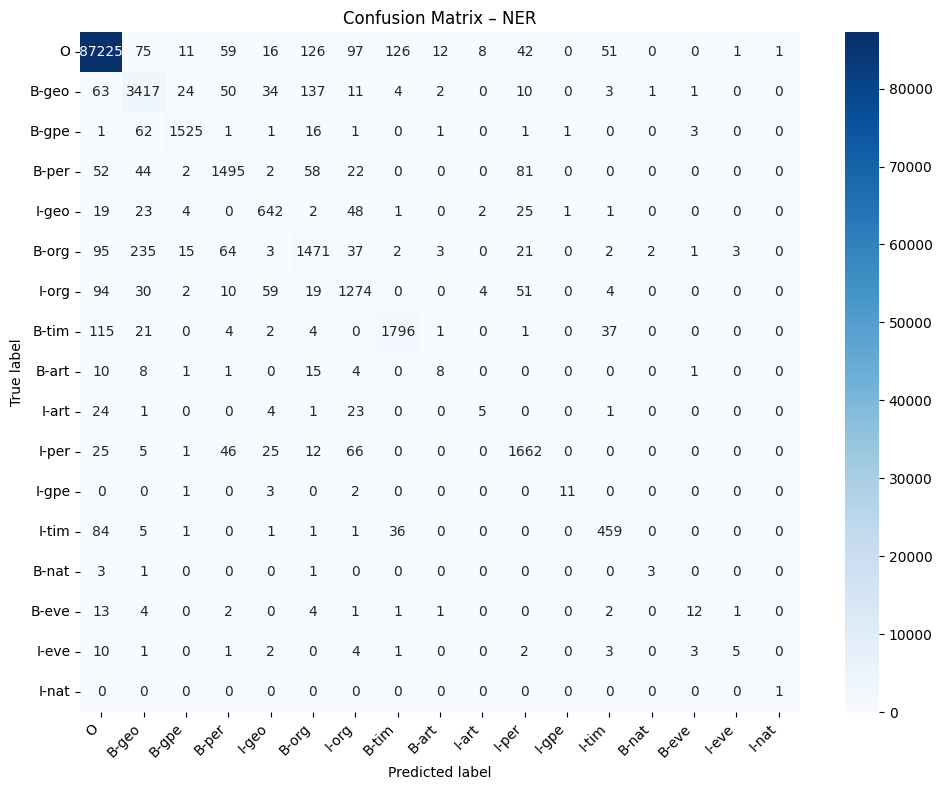

In [31]:
# 1. Thu thập y_true, y_pred trên toàn bộ test set
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for batch in test_dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        logits = model(input_ids=input_ids, attention_mask=attention_mask).logits
        preds = torch.argmax(logits, dim=2)

        # dẹp padding tokens (label == -100)
        for p_seq, l_seq in zip(preds.cpu().numpy(), labels.cpu().numpy()):
            for p, l in zip(p_seq, l_seq):
                if l != -100:
                    all_preds.append(p)
                    all_labels.append(l)

# 2. Tính confusion matrix
# id2label là dict {int: 'B-geo', ...}
labels_list = [id2label[i] for i in sorted(id2label.keys())]
cm = confusion_matrix(all_labels, all_preds, labels=list(sorted(id2label.keys())))

# 3. Vẽ heatmap
plt.figure(figsize=(10,8))
sns.heatmap(cm,
            annot=True,
            fmt='d',
            xticklabels=labels_list,
            yticklabels=labels_list,
            cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix – NER')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## Report

In [32]:
# Lấy danh sách id của các lớp, đã định nghĩa ở chỗ id2label
label_ids = sorted(id2label.keys())
target_names = [id2label[i] for i in label_ids]

# Tạo báo cáo
report = classification_report(
    all_labels,
    all_preds,
    labels=label_ids,
    target_names=target_names,
    zero_division=0    # tránh warn khi 1 label không có mẫu nào
)

print(report)

              precision    recall  f1-score   support

           O       0.99      0.99      0.99     87850
       B-geo       0.87      0.91      0.89      3757
       B-gpe       0.96      0.95      0.95      1613
       B-per       0.86      0.85      0.86      1756
       I-geo       0.81      0.84      0.82       768
       B-org       0.79      0.75      0.77      1954
       I-org       0.80      0.82      0.81      1547
       B-tim       0.91      0.91      0.91      1981
       B-art       0.29      0.17      0.21        48
       I-art       0.26      0.08      0.13        59
       I-per       0.88      0.90      0.89      1842
       I-gpe       0.85      0.65      0.73        17
       I-tim       0.82      0.78      0.80       588
       B-nat       0.50      0.38      0.43         8
       B-eve       0.57      0.29      0.39        41
       I-eve       0.50      0.16      0.24        32
       I-nat       0.50      1.00      0.67         1

    accuracy              